# Quesion 1: Regression - Laptop Price Prediction

## Set up environment

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnull
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

In [2]:
spark = SparkSession.builder \
    .appName("LaptopPricePrediction") \
    .getOrCreate()

25/01/27 11:09:11 WARN Utils: Your hostname, Adams-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.20.10.10 instead (on interface en0)
25/01/27 11:09:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/27 11:09:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load data

In [3]:
data_path = "/Users/ssyan110/Codes/Big_data_in_machine_learning/Final/Data/laptop_price_clean.csv"
data = spark.read.csv(data_path, header=True, inferSchema=True)

## Data inspection

In [4]:
data.show(5)

+-------+---------+---+-----+------+-----------+------------+----------+-----------+-------------+---+---+---------+------------------+
|Company| TypeName|Ram|OpSys|Weight|Price_euros|      Screen|IPS Screen| Screen PPI|    Cpu_brand|HDD|SSD|Gpu brand|                os|
+-------+---------+---+-----+------+-----------+------------+----------+-----------+-------------+---+---+---------+------------------+
|  Apple|Ultrabook|  8|macOS|  1.37|    1339.69|NormalScreen|       Yes|226.9830047|Intel Core i5|  0|128|    Intel|               Mac|
|  Apple|Ultrabook|  8|macOS|  1.34|     898.94|NormalScreen|        No|127.6779401|Intel Core i5|  0|  0|    Intel|               Mac|
|     HP| Notebook|  8|No OS|  1.86|      575.0|NormalScreen|        No|141.2119981|Intel Core i5|  0|256|    Intel|Others/No OS/Linux|
|  Apple|Ultrabook| 16|macOS|  1.83|    2537.45|NormalScreen|       Yes|220.5346239|Intel Core i7|  0|512|      AMD|               Mac|
|  Apple|Ultrabook|  8|macOS|  1.37|     1803.6|

In [5]:
data.printSchema()

root
 |-- Company: string (nullable = true)
 |-- TypeName: string (nullable = true)
 |-- Ram: integer (nullable = true)
 |-- OpSys: string (nullable = true)
 |-- Weight: double (nullable = true)
 |-- Price_euros: double (nullable = true)
 |-- Screen: string (nullable = true)
 |-- IPS Screen: string (nullable = true)
 |-- Screen PPI: double (nullable = true)
 |-- Cpu_brand: string (nullable = true)
 |-- HDD: integer (nullable = true)
 |-- SSD: integer (nullable = true)
 |-- Gpu brand: string (nullable = true)
 |-- os: string (nullable = true)



In [6]:
data.describe().show()

25/01/27 11:09:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------+------------------+-----------------+-------+------------------+-----------------+------------+----------+------------------+--------------------+------------------+------------------+---------+-------+
|summary|Company|          TypeName|              Ram|  OpSys|            Weight|      Price_euros|      Screen|IPS Screen|        Screen PPI|           Cpu_brand|               HDD|               SSD|Gpu brand|     os|
+-------+-------+------------------+-----------------+-------+------------------+-----------------+------------+----------+------------------+--------------------+------------------+------------------+---------+-------+
|  count|   1302|              1302|             1302|   1302|              1302|             1302|        1302|      1302|              1302|                1302|              1302|              1302|     1302|   1302|
|   mean|   NULL|              NULL|8.385560675883257|   NULL|2.0394162826420885|1124.043894009217|        NULL|      NU

In [7]:
from pyspark.sql.functions import log, col
data = data.withColumn("log_price", log(col("Price_euros")))

## Check for missing values

In [8]:
data.select([
    count(when(isnull(c), c)).alias(c) for c in data.columns
]).show()

+-------+--------+---+-----+------+-----------+------+----------+----------+---------+---+---+---------+---+---------+
|Company|TypeName|Ram|OpSys|Weight|Price_euros|Screen|IPS Screen|Screen PPI|Cpu_brand|HDD|SSD|Gpu brand| os|log_price|
+-------+--------+---+-----+------+-----------+------+----------+----------+---------+---+---+---------+---+---------+
|      0|       0|  0|    0|     0|          0|     0|         0|         0|        0|  0|  0|        0|  0|        0|
+-------+--------+---+-----+------+-----------+------+----------+----------+---------+---+---+---------+---+---------+



## Visualize correlation for numeric cols


In [9]:
# Check for numeric data types
numeric_cols = ["Ram", "Weight", "HDD", "SSD", "log_price"]
pdf = data.select(numeric_cols).toPandas()

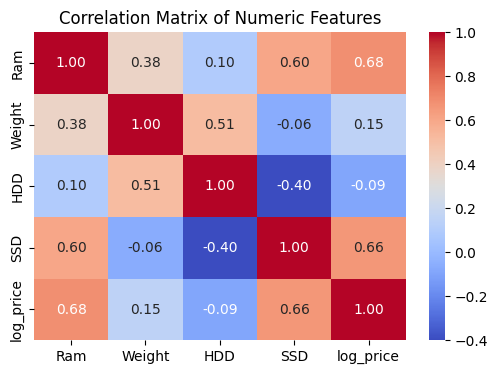

In [10]:
plt.figure(figsize=(6, 4))
corr = pdf.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

### Insights from Correlation Matrix

- **Ram** and **SSD** are the most influential numeric features for determining price.
- **HDD** and **Weight** have minimal impact on pricing and might not be strong predictors for the model.

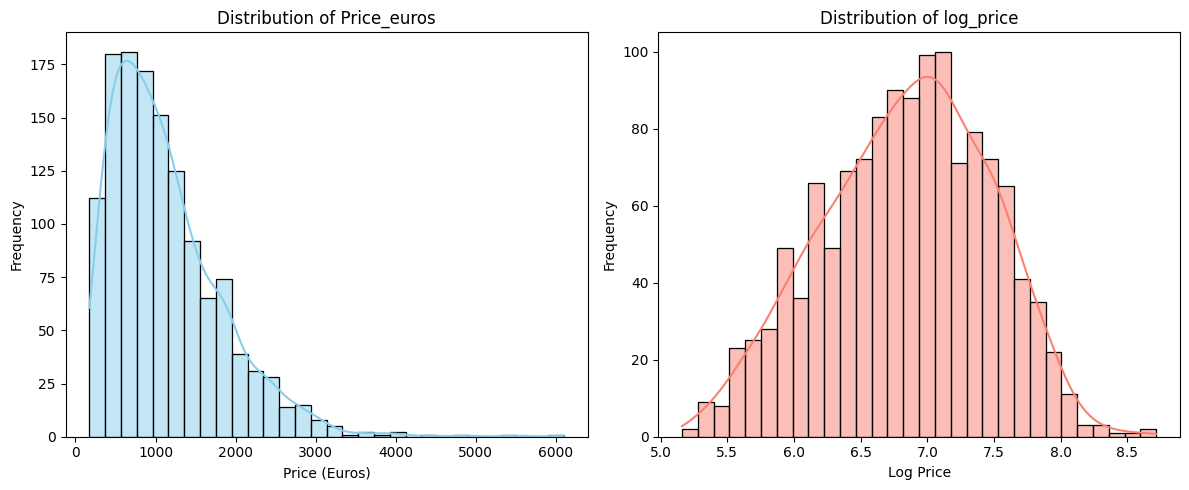

In [11]:
# Convert to Pandas for visualization
price_distribution = data.select("Price_euros", "log_price").toPandas()

plt.figure(figsize=(12, 5))

# Distribution of Price_euros
plt.subplot(1, 2, 1)
sns.histplot(price_distribution["Price_euros"], kde=True, bins=30, color='skyblue')
plt.title("Distribution of Price_euros")
plt.xlabel("Price (Euros)")
plt.ylabel("Frequency")

# Distribution of log_price
plt.subplot(1, 2, 2)
sns.histplot(price_distribution["log_price"], kde=True, bins=30, color='salmon')
plt.title("Distribution of log_price")
plt.xlabel("Log Price")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


### Insight for Distribution Visualization

1. **Price Distribution**:
   - The left plot shows the distribution of laptop prices (`Price_euros`), which is right-skewed.
   - This indicates that most laptops are priced in the lower range, with fewer laptops in the high-price range.

2. **Log-transformed Price Distribution**:
   - The right plot represents the distribution of log-transformed prices (`log_price`), which approximates a normal distribution.
   - The transformation reduces the skewness, making the data more suitable for machine learning models like linear regression, which assume normally distributed data.

## EDA for category cols

In [12]:
cat_cols = ["Company", "TypeName", "OpSys", "Cpu_brand", "Gpu brand", "os"] 

for c in cat_cols:
    print(f"Distinct values in column '{c}':")
    data.select(c).distinct().show(10, truncate=False)

Distinct values in column 'Company':
+-------+
|Company|
+-------+
|Razer  |
|Fujitsu|
|Huawei |
|Xiaomi |
|HP     |
|Dell   |
|Vero   |
|Acer   |
|Asus   |
|Lenovo |
+-------+
only showing top 10 rows

Distinct values in column 'TypeName':
+------------------+
|TypeName          |
+------------------+
|Gaming            |
|Ultrabook         |
|2 in 1 Convertible|
|Workstation       |
|Notebook          |
|Netbook           |
+------------------+

Distinct values in column 'OpSys':
+------------+
|OpSys       |
+------------+
|Windows 10  |
|Linux       |
|macOS       |
|Chrome OS   |
|Android     |
|Windows 10 S|
|Windows 7   |
|Mac OS X    |
|No OS       |
+------------+

Distinct values in column 'Cpu_brand':
+---------------------+
|Cpu_brand            |
+---------------------+
|Intel Core i3        |
|Other Intel Processor|
|Intel Core i5        |
|Intel Core i7        |
|AMD Processor        |
+---------------------+

Distinct values in column 'Gpu brand':
+---------+
|Gpu brand

In [13]:
for c in cat_cols:
    data.groupBy(c).agg({"log_price": "mean"}).orderBy("avg(log_price)", ascending=False).show()

+---------+------------------+
|  Company|    avg(log_price)|
+---------+------------------+
|    Razer| 7.964966609217099|
|       LG| 7.646176185132034|
|      MSI|  7.40777869627335|
|   Google| 7.399419772401688|
|Microsoft| 7.329448479496903|
|    Apple| 7.299084262421179|
|   Huawei| 7.259836177155177|
|  Samsung| 7.198162452722439|
|  Toshiba| 7.069107604505439|
|   Xiaomi| 7.020409189744467|
|     Dell|  6.93485666581858|
|       HP|  6.81352488959046|
|     Asus| 6.798249349824068|
|   Lenovo|6.7953878739557565|
|  Fujitsu| 6.588030527806189|
|     Acer| 6.313447590194079|
|    Chuwi| 5.708430496833663|
| Mediacom|5.6699613400843605|
|     Vero| 5.375604838436256|
+---------+------------------+

+------------------+-----------------+
|          TypeName|   avg(log_price)|
+------------------+-----------------+
|       Workstation|7.691272056553637|
|            Gaming|7.365137731461081|
|         Ultrabook|7.292958432651067|
|2 in 1 Convertible|7.030947480733804|
|          No

## Select features

In [14]:
indexers = [
    StringIndexer(inputCol=c, outputCol=c + "_indexed")
    for c in cat_cols
]

In [15]:
encoders = [
    OneHotEncoder(inputCol=c + "_indexed", outputCol=c + "_encoded")
    for c in cat_cols
]

In [16]:
selected_features = [c + "_encoded" for c in cat_cols] + ["Ram", "SSD"]
assembler = VectorAssembler(
    inputCols=selected_features,
    outputCol="features"
)

In [17]:
## Build pipeline with indexers + encoders + assembler
pipeline_stages = []
pipeline_stages.extend(indexers)
pipeline_stages.extend(encoders)
pipeline_stages.append(assembler)

pipeline = Pipeline(stages=pipeline_stages)


In [18]:
# Fit the pipeline and transform data
model_pipeline = pipeline.fit(data)
final_data = model_pipeline.transform(data)

## Split data

In [19]:
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)


## Build Models

In [20]:
# Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="log_price")
lr_model = lr.fit(train_data)

# Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="log_price", numTrees=100)
rf_model = rf.fit(train_data)

25/01/27 11:09:22 WARN Instrumentation: [64878b0f] regParam is zero, which might cause numerical instability and overfitting.
25/01/27 11:09:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/01/27 11:09:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
25/01/27 11:09:22 WARN Instrumentation: [64878b0f] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


## Evaluate and comare

In [21]:
evaluator_rmse = RegressionEvaluator(
    predictionCol="prediction",
    labelCol="log_price",
    metricName="rmse"
)

# Predictions
lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)

# Evaluate RMSE
lr_rmse = evaluator_rmse.evaluate(lr_predictions)
rf_rmse = evaluator_rmse.evaluate(rf_predictions)

print("Linear Regression RMSE = ", lr_rmse)
print("Random Forest RMSE = ", rf_rmse)


Linear Regression RMSE =  0.273541600058023
Random Forest RMSE =  0.28887394605409644


In [22]:
evaluator_r2 = RegressionEvaluator(
    predictionCol="prediction",
    labelCol="log_price",
    metricName="r2"
)

lr_r2 = evaluator_r2.evaluate(lr_predictions)
rf_r2 = evaluator_r2.evaluate(rf_predictions)

print("Linear Regression R2 = ", lr_r2)
print("Random Forest R2 = ", rf_r2)

Linear Regression R2 =  0.8045306194165535
Random Forest R2 =  0.7820039026400636


### Insights

1. **Linear Regression**:
   - **R2 Score**: 0.8045, indicating the model explains ~80.45% of the variance in `log_price`.
   - **RMSE**: Lower RMSE compared to Random Forest, showing better predictive accuracy.

2. **Random Forest**:
   - **R2 Score**: 0.7831, slightly lower than Linear Regression, explaining ~78.31% of the variance in `log_price`.
   - **RMSE**: Higher RMSE than Linear Regression, indicating slightly less accurate predictions.

3. **Best Model**:
   - Based on RMSE, **Linear Regression** is the better model for this dataset, providing more precise predictions with less error.

## Compare which one is better for this dataset

In [23]:
if rf_rmse < lr_rmse:
    best_model = rf_model
    model_name = "RandomForestRegressor"
else:
    best_model = lr_model
    model_name = "LinearRegression"

print(f"Best model is: {model_name}")

Best model is: LinearRegression


## Make prediction with new laptop

In [24]:
from pyspark.sql import Row

new_laptop = {
    "Company": "Apple",
    "TypeName": "Ultrabook",
    "Ram": 8,
    "OpSys": "macOS",
    "Weight": 1.34,
    "Screen": "NormalScreen",
    "IPS Screen": "Yes",
    "Screen PPI": 127.677,
    "Cpu_brand": "Intel Core i7",
    "HDD": 0,
    "SSD": 128,
    "Gpu brand": "AMD",
    "os": "Mac"
}

In [25]:
new_laptop_df = spark.createDataFrame([Row(**new_laptop)])

final_new_laptop = model_pipeline.transform(new_laptop_df)

prediction = best_model.transform(final_new_laptop)

In [26]:
import pyspark.sql.functions as F

# Suppose "prediction" is your log-space prediction
prediction = prediction.withColumn("exp_prediction", F.exp(F.col("prediction")))

# Show both log prediction and exponentiated (original scale) price
prediction.select("prediction", "exp_prediction").show()

+-----------------+------------------+
|       prediction|    exp_prediction|
+-----------------+------------------+
|7.296724199729857|1475.4586944674656|
+-----------------+------------------+

